In [2]:
import os
import torch
import torchvision
import pickle
import copy
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset as Dataset
from torchvision import datasets, transforms, models
from matplotlib.pyplot import imshow
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

### Function to calculate the mean and standard deviation

In [4]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0

    for images, _ in loader:
        # Rearrange images to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total number of images
        num_pixels += images.size(0)
        # Compute mean and std here
        mean += images.mean(2).sum(0) 
        std += images.std(2).sum(0)

    mean /= num_pixels
    std /= num_pixels

    return mean, std

CIFAR-10 is a popular dataset containing 60,000 color images with a resolution of 32x32 pixels, divided into 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset consists of 50,000 training images and 10,000 test images.

### Data loading

In [6]:
train_dataset_base = torchvision.datasets.CIFAR10(
    root='/kaggle/working/cifar-10/Cifar-10',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 170M/170M [00:04<00:00, 42.6MB/s] 


In [7]:
trainloader0 = torch.utils.data.DataLoader(train_dataset_base, batch_size=64, shuffle=True)
mean, std = get_mean_std(trainloader0)

print(mean)
print(std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2023, 0.1994, 0.2010])


### Visualization

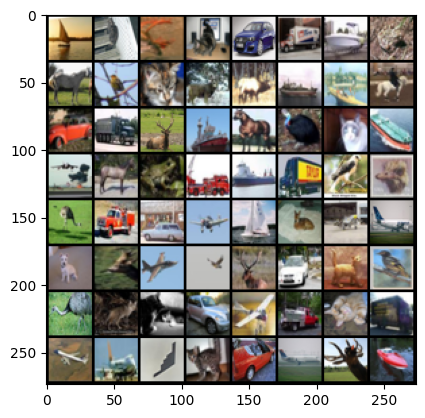

In [8]:
images, labels = next(iter(trainloader0))


def image_viz(img):
    image = img.numpy()
    image = np.transpose(image, (1, 2, 0))
    imshow(image)
fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)

### Data loading with normalization

In [9]:
train_dataset0 = torchvision.datasets.CIFAR10(
    root='/kaggle/working/cifar-10/Cifar-10',
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                 ])
)

### Splitting into training and validation sets

In [10]:
train_dataset2, val_dataset = torch.utils.data.random_split(train_dataset0, [40000, 10000])

### Training set with augmentation

In [11]:
train_dataset_transformed = torchvision.datasets.CIFAR10(
    root='/kaggle/working/cifar-10/Cifar-10',
    train=True,
    download=False,
    transform=transforms.Compose([transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                  transforms.RandomRotation(20),     # Rotates the image to a specified angel
                                  transforms.ToTensor(), # Converts the image to tensor 
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize images
                                 ])
)

len(train_dataset_transformed)

50000

### Adding to the dataset after augmentation

In [12]:
train_dataset = torch.utils.data.ConcatDataset([train_dataset_transformed ,train_dataset2])

### Loading the test set

In [13]:
test_dataset = torchvision.datasets.CIFAR10(
    root="/kaggle/working/cifar-10/Cifar-10",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                 ])
)

In [35]:
print(f"After splitting: \n train: {len(train_dataset)} \n val: {len(val_dataset)} \n test: {len(test_dataset)}")

After splitting: 
 train: 90000 
 val: 10000 
 test: 10000


In [15]:
print(test_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Dataloaders

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) # po augmentacji

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False) # testowy

validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False) # walidacyjny

In [19]:
print(len(trainloader))
print(len(testloader))
print(len(validation_loader))

2813
313
313


### Images after transformations

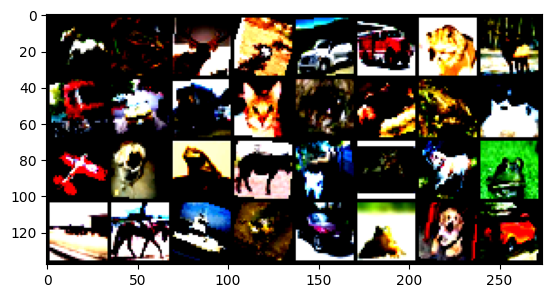

In [20]:
images, labels = next(iter(trainloader))
fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()                       
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # przyjmuje 32 i przekształca na 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # output: 128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # output: 256 x 4 x 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # przekształca dane za wymiarów 256 x 4 x 4 na wektor jednowymiarowy o rozmiarze 4352x1 
            nn.Linear(256*4*4, 512), #redukcja wymiarów do 512
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
            

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

### Training loop

In [23]:
# Training loop

def train(model, train_dataloader, validation_dataloader, loss_fn, optimizer, num_epoch, device):
    
    train_loss_list = []  #training loss 
    train_acc_list = []  # training accuracy
    val_loss_list = [] # validation loss
    val_acc_list = [] # validation accuracy
    
    # zmienne do early stopping
    best_loss = float('inf')
    patience = 10
    best_model_weights = None
    
    for epoch in range(num_epoch): #tqdm
        running_loss = 0
        corrects = 0
        val_running_loss = 0
        val_corrects = 0
        n=0
        val_n=0
        
        model.train()
        for batch in train_dataloader:
            images, labels = batch
            
            #Puta data on target device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            #Calculate loss
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            # Optimize and backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculating accuracy
            _, preds = torch.max(outputs, 1)
            corrects += (preds == labels).sum().item()
            n += labels.size(0)

        train_loss_list.append(running_loss / len(train_dataloader)) # loss per epoch
        train_acc_list.append(100* corrects / n) #acc per epoch

        
        model.eval()
        with torch.no_grad():
            for val_images, val_labels in validation_dataloader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = loss_fn(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_preds = torch.max(val_outputs, 1)
                val_corrects += (val_preds == val_labels).sum().item()
                val_n += val_labels.size(0)



        val_loss_list.append(val_running_loss / len(validation_dataloader))
        val_acc_list.append(100 * val_corrects / val_n)

        if epoch % 10 == 0 or epoch-1 == num_epoch:
            print(f'Epoch [{epoch+1}/{num_epoch}]')
            print(f'\t validation loss: {val_loss_list[epoch]}, validation accuracy: {val_acc_list[epoch]}')
            print(f'\t training loss: {train_loss_list[epoch]}, training accuracy: {train_acc_list[epoch]}')

        
        # Early stopping
        if val_loss_list[epoch] < best_loss:
            best_loss = val_loss_list[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())   
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print(f"early stopping at epoch {epoch+1}")
                break
    
    
    model.load_state_dict(best_model_weights)
    return {"val_loss": val_loss_list, "val_acc": val_acc_list, "train_loss": train_loss_list, "train_acc": train_acc_list}

### Evaluation

In [24]:
#model evaluation
def evaluation(dataloader, model, loss_fn):
    model.eval()
    classes = test_dataset.classes
    total, correct = 0, 0
    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]
    running_loss = 0
    n=0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            pred = model.forward(images)
            _, predicted = torch.max(pred.data, 1)

            #Calculating loss
            loss = loss_fn(pred, labels)
            running_loss += loss.item()

            #Calculatin accuracy
            n += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            #Calculating accuracy per batch
            for i in range(labels.size(0)):  
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    class_correct[label] += 1
                class_total[label] += 1
                
        acc = 100.0 * correct / n
        print(f'Accuracy of the network: {acc} %')
        print(f"Loss: {running_loss / n} \n")
        
        print("Accuracy per class: ")
        for i in range(10):
            acc = 100.0 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]}: {acc} %')

In [25]:
mod2 = Net2().to(device)

summary(mod2, [1,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 16, 16]          256
│    └─ReLU: 2-10                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-11                      [1, 128, 16, 16]          147,584

![konwolucja_diagram](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*kkyW7BR5FZJq4_oBTx3OPQ.png)

In [26]:
loss_fn1 = torch.nn.CrossEntropyLoss()

optimizer2 = torch.optim.Adam(mod2.parameters(), lr=0.001)

train_mod2 = train(model=mod2,
                  train_dataloader=trainloader,
                  loss_fn=loss_fn1,
                  num_epoch=100,
                  optimizer=optimizer2,
                  validation_dataloader=validation_loader,
                  device=device)

Epoch [1/100]
	 validation loss: 1.0052156625464321, validation accuracy: 63.75
	 training loss: 1.399828616999834, training accuracy: 48.97222222222222
Epoch [11/100]
	 validation loss: 0.28887043631495757, validation accuracy: 90.19
	 training loss: 0.3008886929886158, training accuracy: 90.10888888888888
Epoch [21/100]
	 validation loss: 0.18248327286503377, validation accuracy: 93.93
	 training loss: 0.18413858171310732, training accuracy: 94.05888888888889
Epoch [31/100]
	 validation loss: 0.12029247094219485, validation accuracy: 95.87
	 training loss: 0.14679491685444246, training accuracy: 95.30444444444444
Epoch [41/100]
	 validation loss: 0.08532169177446115, validation accuracy: 97.08
	 training loss: 0.1211232908627209, training accuracy: 96.13111111111111
Epoch [51/100]
	 validation loss: 0.0618080684588627, validation accuracy: 97.96
	 training loss: 0.10230288571077754, training accuracy: 96.68888888888888
Epoch [61/100]
	 validation loss: 0.06096244308079917, validation

Early stopping at 92 epoch.

### Saving the model

In [27]:
with open("train_mod2", "wb") as fp: #Pickling
    pickle.dump(train_mod2, fp)


torch.save(mod2, "mod2.pth")

In [ ]:
#with open("train_mod2", "rb") as fp:   # Unpickling
#    train_mod2 = pickle.load(fp)

In [28]:
mod2 = torch.load("/kaggle/working/mod2.pth", weights_only=False, map_location=torch.device(device))
#mod2.eval()

### Visualizations

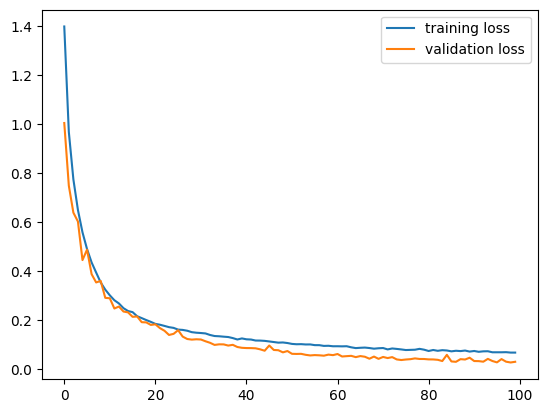

In [29]:
plt.plot(train_mod2["train_loss"], label = "training loss")
plt.plot(train_mod2["val_loss"], label = "validation loss")
plt.legend()
plt.show()

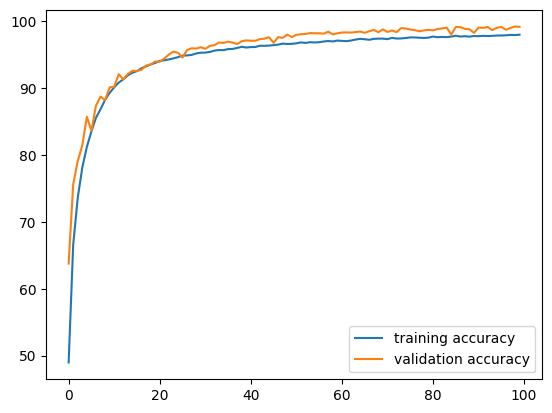

In [30]:
plt.plot(train_mod2["train_acc"], label = "training accuracy")
plt.plot(train_mod2["val_acc"], label = "validation accuracy")
plt.legend()
plt.show()

In [31]:
evaluation(testloader, mod2, loss_fn1)

Accuracy of the network: 89.67 %
Loss: 0.013386168325971812 

Accuracy per class: 
Accuracy of airplane: 88.7 %
Accuracy of automobile: 93.4 %
Accuracy of bird: 87.7 %
Accuracy of cat: 78.5 %
Accuracy of deer: 92.1 %
Accuracy of dog: 83.3 %
Accuracy of frog: 93.0 %
Accuracy of horse: 89.8 %
Accuracy of ship: 96.1 %
Accuracy of truck: 94.1 %


In [32]:
def plot_conf_mat(model):
    preds_list = []
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
    
            # Forward pass
            pred = model.forward(images)
            _, predicted = torch.max(pred.data, 1)
            preds_list.extend(predicted.cpu())
    
    
    c_f = confusion_matrix(preds_list, test_dataset.targets)
    
    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat= c_f, 
        class_names=test_dataset.classes,
        figsize=(10, 7))

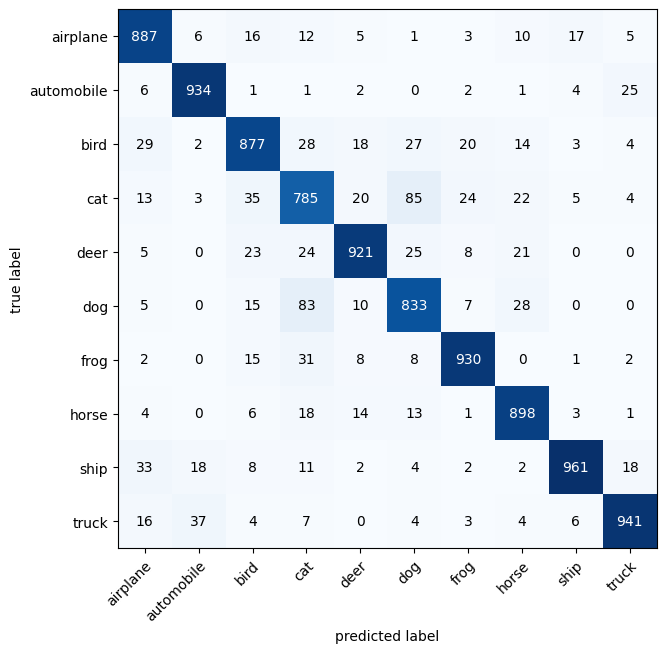

In [33]:
plot_conf_mat(mod2)